<a href="https://colab.research.google.com/github/NolanRink/CS4540/blob/main/Project3/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep State Classification with FFNNs in PyTorch

This notebook classifies local field potential (LFP) signals into **NREM** and **WAKE** states using feedforward neural networks (FFNNs) in PyTorch. We process data for three subjects, extract features, train multiple networks with different complexities, and visualize the results and performance.


## 1. Data Loading

Load the LFP data for three subjects from the following files (upload them manually to Colab):
- "Rat08-20130711_017.h5"
- "Part1SubjectHB10.h5"
- "Part2SubjectHB13.h5"

In [1]:
import h5py
import numpy as np

# File paths for the three subjects
files = [
    "Rat08-20130711_017.h5",
    "Part1SubjectHB10.h5",
    "Part2SubjectHB13.h5"
]

# Define subject names corresponding to each file
subject_names = ["Rat08_HPC", "SubjectHB10_BLA", "SubjectHB13_BLA"]

data_dict = {}

for subject, filename in zip(subject_names, files):
    segments, labels = [], []
    with h5py.File(filename, 'r') as f:
        fs = f.attrs.get('fs', 1250)
        for state in f.keys():
            lab = 1 if state == "NREM" else 0
            for seg in f[state].values():
                segments.append(seg[()].astype(float))
                labels.append(lab)
    data_dict[subject] = {"segments": segments, "labels": np.array(labels), "fs": fs}
    print(f"{subject}: Loaded {len(segments)} segments")


Rat08_HPC: Loaded 96 segments
SubjectHB10_BLA: Loaded 55 segments
SubjectHB13_BLA: Loaded 41 segments


## 2. Preprocessing

Split each segment into 5-second clips and label them (0 for WAKE, 1 for NREM).



In [2]:
clip_duration = 5  #seconds
processed_data = {}

for subject in subject_names:
    fs = data_dict[subject]["fs"] if "fs" in data_dict[subject] else default_fs
    clip_length = int(clip_duration * fs)
    X_clips = []
    y_clips = []

    segs = data_dict[subject]["segments"]
    labs = data_dict[subject]["labels"]
    for seg, lab in zip(segs, labs):
        if len(seg) < clip_length:
            continue
        n_clips = len(seg) // clip_length
        # Only use full clips
        seg_clips = seg[:n_clips * clip_length].reshape(n_clips, clip_length)
        for clip in seg_clips:
            X_clips.append(clip)
        y_clips.extend([lab] * n_clips)

    X_clips = np.array(X_clips)
    y_clips = np.array(y_clips)
    print(f"{subject}: total {len(X_clips)} clips ({sum(y_clips==1)} NREM, {sum(y_clips==0)} WAKE).")
    processed_data[subject] = {"X": X_clips, "y": y_clips, "fs": fs}


<ipython-input-2-53740184b823>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clip_length = int(clip_duration * fs)


Rat08_HPC: total 3682 clips (1239 NREM, 2443 WAKE).
SubjectHB10_BLA: total 907 clips (330 NREM, 577 WAKE).
SubjectHB13_BLA: total 913 clips (295 NREM, 618 WAKE).


## 3. Feature Extraction

For each 5-second clip, extract the following features:
- Time domain: mean, standard deviation, skewness, kurtosis.
- Frequency domain: Band power features in delta, theta, alpha, beta, and gamma bands using Welch’s PSD.

In [11]:
from scipy.signal import welch
from scipy.stats import skew, kurtosis

# Define frequency bands
# used from here https://www.researchgate.net/post/What-is-the-basic-knowledge-or-assumption-to-the-classification-of-brain-wave-rhythm-delta-theta-alpha-beta-gamma-bands#:~:text=delta%280.5
bands = {
    "delta": (0.5, 4), #hz
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 100)
}


#Using Welch's method from here https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
for subject in subject_names:
    X_clips = processed_data[subject]["X"]
    fs = processed_data[subject]["fs"]
    features = []
    for clip in X_clips:

        mu = np.mean(clip)
        sigma = np.std(clip)
        sk_val = skew(clip)
        ku_val = kurtosis(clip)

        freqs, psd = welch(clip, fs, nperseg=256)
        band_powers = []
        for low, high in bands.values():
            mask = (freqs >= low) & (freqs < high)
            power = np.trapezoid(psd[mask], freqs[mask]) if np.any(mask) else 0
            band_powers.append(power)
        features.append([mu, sigma, sk_val, ku_val] + band_powers)
    features = np.array(features)
    processed_data[subject]["features"] = features
    print(f"{subject}: Extracted features shape = {features.shape}")


Rat08_HPC: Extracted features shape = (3682, 9)
SubjectHB10_BLA: Extracted features shape = (907, 9)
SubjectHB13_BLA: Extracted features shape = (913, 9)


## 4. Exploratory Visualization

Visualize the PSD and feature distributions for Subject "Rat08_HPC" as an example.


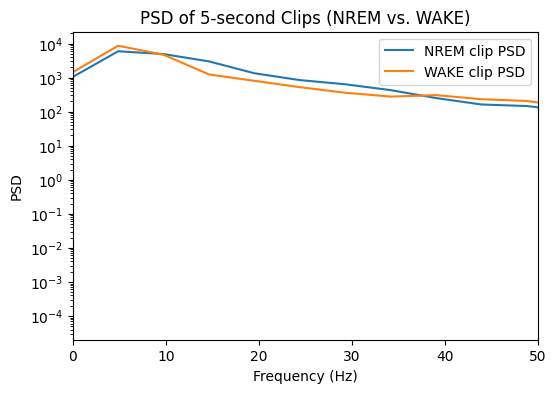

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: PSD plot for one NREM clip vs. one WAKE clip from "Rat08_HPC"
fs = processed_data["Rat08_HPC"]["fs"]
# Assuming the first clip is NREM and the last clip is WAKE (based on original ordering)
example_nrem_clip = processed_data["Rat08_HPC"]["X"][0]
example_wake_clip = processed_data["Rat08_HPC"]["X"][-1]
freqs_n, psd_n = welch(example_nrem_clip, fs, nperseg=256)
freqs_w, psd_w = welch(example_wake_clip, fs, nperseg=256)

plt.figure(figsize=(6,4))
plt.semilogy(freqs_n, psd_n, label='NREM clip PSD')
plt.semilogy(freqs_w, psd_w, label='WAKE clip PSD')
plt.xlim(0, 50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('PSD of 5-second Clips (NREM vs. WAKE)')
plt.legend()
plt.show()


## 5. Data Splitting and Normalization

Split the data into training (70%), validation (15%), and test (15%) sets. Normalize features using z-score normalization based on the training set.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

splits = {}

for subject in subject_names:
    X = processed_data[subject]["features"]
    y = processed_data[subject]["y"]
    # Split: Train+Val and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)
    # Further split Train+Val into Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.15/0.85, random_state=42, stratify=y_train_val)
    # Normalize using training set statistics only
    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc   = scaler.transform(X_val)
    X_test_sc  = scaler.transform(X_test)
    splits[subject] = {
        "X_train": X_train_sc, "y_train": y_train,
        "X_val": X_val_sc,     "y_val": y_val,
        "X_test": X_test_sc,   "y_test": y_test
    }
    print(f"{subject}: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)} clips")


Rat08_HPC: Train=2576, Val=553, Test=553 clips
SubjectHB10_BLA: Train=634, Val=136, Test=137 clips
SubjectHB13_BLA: Train=639, Val=137, Test=137 clips


## 6. Model Definitions: Simple and Complex FFNNs

Define two FFNN architectures:
- **SimpleFFNN:** One hidden layer.
- **ComplexFFNN:** Two hidden layers.


In [6]:
import torch
import torch.nn as nn

# Simple FFNN with one hidden layer
class SimpleFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, output_dim=2):
        super(SimpleFFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Complex FFNN with two hidden layers
class ComplexFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], output_dim=2):
        super(ComplexFFNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


## 7. Training the Models

Train both models (SimpleFFNN and ComplexFFNN) on the training data for each subject. We monitor training and validation accuracy across epochs.

The training function takes the data, trains the model for a specified number of epochs, and returns the accuracy history.



In [23]:
import torch.optim as optim

def train_ffnn(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.01):
    # Convert arrays to PyTorch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t   = torch.tensor(X_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_acc": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            _, pred_train = torch.max(outputs, 1)
            _, pred_val = torch.max(model(X_val_t), 1)
            train_acc = (pred_train == y_train_t).float().mean().item()
            val_acc = (pred_val == y_val_t).float().mean().item()

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if epoch == 1 or epoch % 100 == 0 or epoch == epochs:
            print(f"Epoch {epoch:2d}/{epochs}: Train Acc = {train_acc*100:.1f}%, Val Acc = {val_acc*100:.1f}%")

    return history

# Train models for each subject
histories = {}  # Store training histories for plotting
models = {}     # Store the trained models

# Test different learning rates
for lr in [.001, .01, .05]:
  print(f"\nTraining with learning rate {lr}")
  for subject in subject_names:
      input_dim = splits[subject]["X_train"].shape[1]
      print(f"\nSubject {subject} - Training Simple FFNN")
      model_simple = SimpleFFNN(input_dim=input_dim, hidden_dim=16, output_dim=2)
      hist_simple = train_ffnn(model_simple,
                                splits[subject]["X_train"], splits[subject]["y_train"],
                                splits[subject]["X_val"], splits[subject]["y_val"],
                                epochs=1000, lr=0.01)

      print(f"\nSubject {subject} - Training Complex FFNN")
      model_complex = ComplexFFNN(input_dim=input_dim, hidden_dims=[32, 16], output_dim=2)
      hist_complex = train_ffnn(model_complex,
                                  splits[subject]["X_train"], splits[subject]["y_train"],
                                  splits[subject]["X_val"], splits[subject]["y_val"],
                                  epochs=1000, lr=0.01)

      histories[subject] = {"simple": hist_simple, "complex": hist_complex}
      models[subject] = {"simple": model_simple, "complex": model_complex}



Training with learning rate 0.001

Subject Rat08_HPC - Training Simple FFNN
Epoch  1/1000: Train Acc = 65.6%, Val Acc = 67.6%
Epoch 100/1000: Train Acc = 92.2%, Val Acc = 90.6%
Epoch 200/1000: Train Acc = 92.9%, Val Acc = 90.6%
Epoch 300/1000: Train Acc = 93.8%, Val Acc = 91.3%
Epoch 400/1000: Train Acc = 93.8%, Val Acc = 91.9%
Epoch 500/1000: Train Acc = 93.8%, Val Acc = 92.2%
Epoch 600/1000: Train Acc = 94.0%, Val Acc = 92.0%
Epoch 700/1000: Train Acc = 94.0%, Val Acc = 92.0%
Epoch 800/1000: Train Acc = 94.1%, Val Acc = 91.9%
Epoch 900/1000: Train Acc = 94.2%, Val Acc = 91.3%
Epoch 1000/1000: Train Acc = 94.3%, Val Acc = 91.1%

Subject Rat08_HPC - Training Complex FFNN
Epoch  1/1000: Train Acc = 33.7%, Val Acc = 67.8%
Epoch 100/1000: Train Acc = 93.6%, Val Acc = 91.1%
Epoch 200/1000: Train Acc = 94.4%, Val Acc = 90.2%
Epoch 300/1000: Train Acc = 95.1%, Val Acc = 91.0%
Epoch 400/1000: Train Acc = 95.6%, Val Acc = 90.8%
Epoch 500/1000: Train Acc = 96.0%, Val Acc = 91.5%
Epoch 600/1000

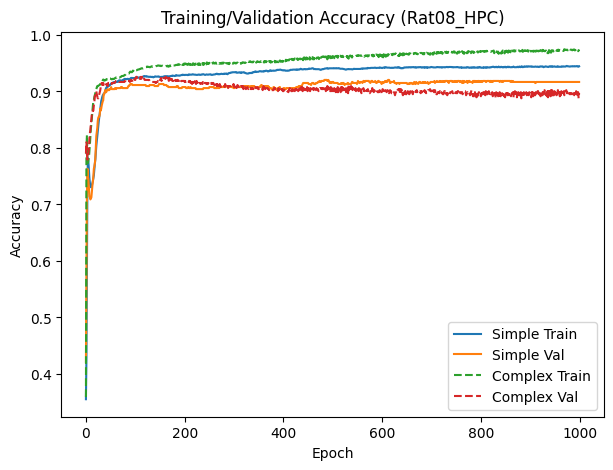

In [24]:
plt.figure(figsize=(7,5))
plt.plot(histories["Rat08_HPC"]["simple"]["train_acc"], label="Simple Train")
plt.plot(histories["Rat08_HPC"]["simple"]["val_acc"], label="Simple Val")
plt.plot(histories["Rat08_HPC"]["complex"]["train_acc"], '--', label="Complex Train")
plt.plot(histories["Rat08_HPC"]["complex"]["val_acc"], '--', label="Complex Val")
plt.title("Training/Validation Accuracy (Rat08_HPC)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 8. Evaluating the Models

Evaluate both models on the test data for each subject. Print the test accuracy and display the confusion matrix.



Evaluation for Rat08_HPC:


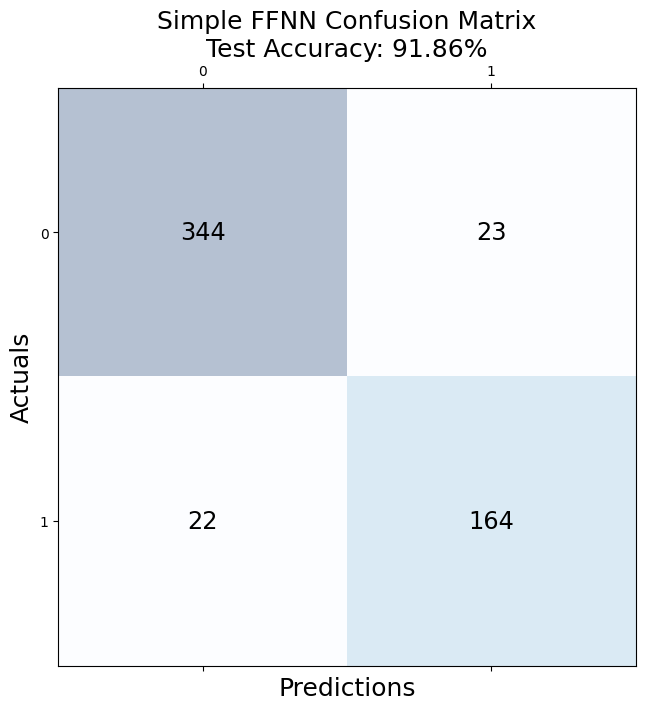

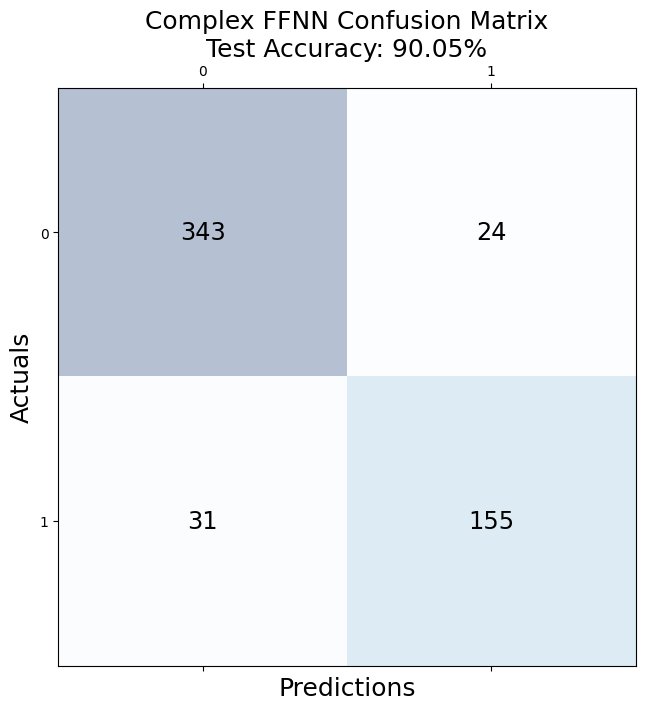


Evaluation for SubjectHB10_BLA:


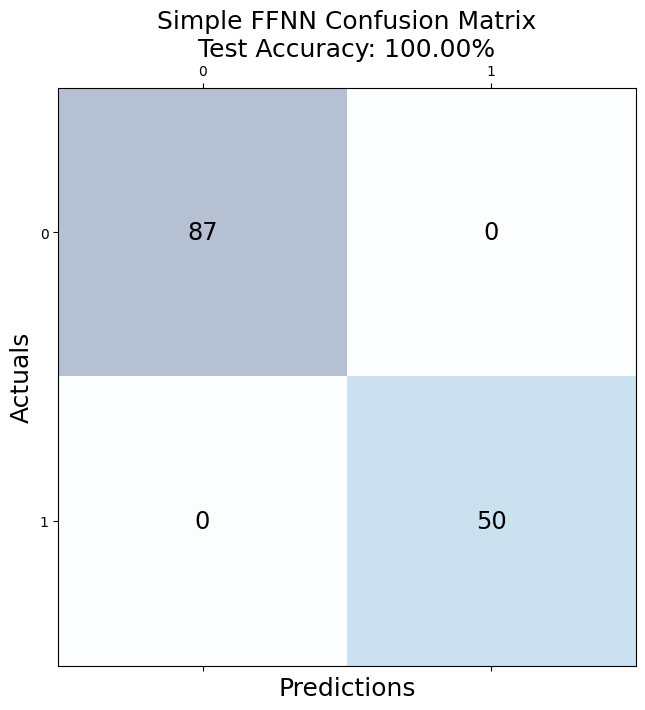

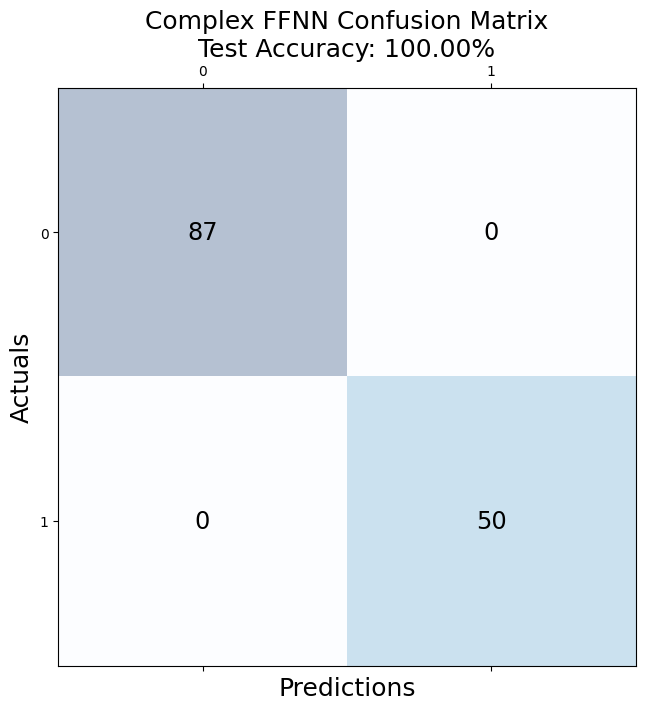


Evaluation for SubjectHB13_BLA:


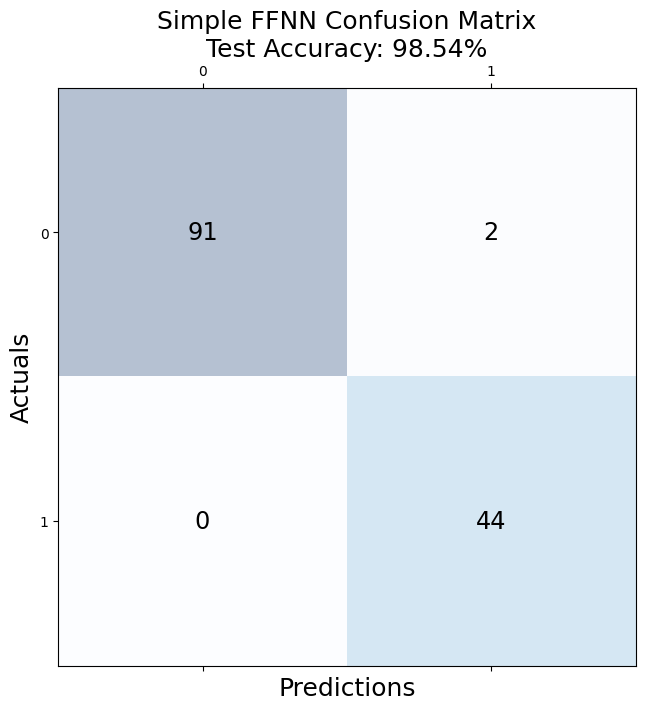

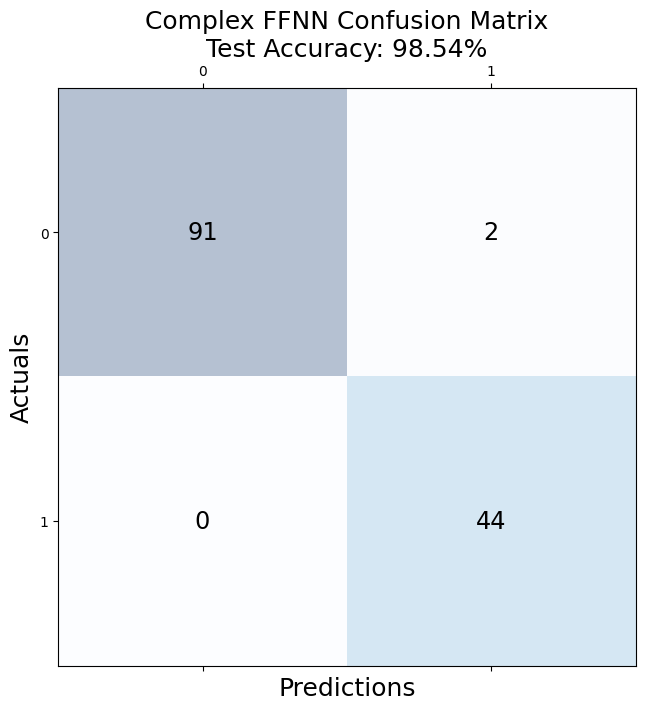

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

for subject in subject_names:
    print(f"\nEvaluation for {subject}:")
    X_test = torch.tensor(splits[subject]["X_test"], dtype=torch.float32)
    y_test = splits[subject]["y_test"]
    for model_type in ["simple", "complex"]:
        model = models[subject][model_type]
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            _, y_pred = torch.max(outputs, 1)
            y_pred = y_pred.numpy()
        acc = (y_pred == y_test).mean()
        cm = confusion_matrix(y_test, y_pred)


        # Create the subplot for the confusion matrix.
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

        # Annotate each cell with its numerical value.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title(f"{model_type.capitalize()} FFNN Confusion Matrix\nTest Accuracy: {acc*100:.2f}%", fontsize=18)
        plt.show()


## 9. Results Summary and Discussion

**Summary:**

All three subjects achieved robust classification of sleep state using feedforward networks. Delta power proved highly discriminative for NREM, while higher-frequency power was prevalent during wakefulness. Both simple and complex FFNNs performed similarly, suggesting the extracted 9-dimensional features are sufficiently informative. Issues such as potential feature redundancy and class imbalance were mitigated through feature normalization and stratified data splitting.